In [2]:
import pandas as pd
import altair as alt
import numpy as np
from pathlib import Path
from helpers import read
import bottleneck as bn
import re
from algo import symmetrized_KLD
import string
from glob import glob
from collections import Counter
from datetime import datetime

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [2]:
heb_cols = ["שם ישוב", "סמל ישוב", "בזב", "מצביעים", "פסולים", "כשרים"]
eng_cols = ["town_name", "town_code", "bzb", "voters", "valid_votes", "invalid_votes"]
years = (
    "2015",
    "2019a",
    "2019b",
    "2020",
    "2021",
)  #  ("2015 - hebrew", "2019 - hebrew",
drop_cols = {
    "2019b": ["סמל ועדה"],
    "2020": ["סמל ועדה", "Unnamed: 37"],
    "2021": ["סמל ועדה", "Unnamed: 46"],
} | {y: [] for y in years[:-3]}
emet_df = []
kv_df = []
for year in years:
    df = (
        pd.read_csv(
            f"data/elections/votes per settlement {year}.csv", encoding="iso8859_8"
        )
        .rename(columns=dict(zip(heb_cols, eng_cols)))
        .drop(columns=drop_cols[year])
        .melt(id_vars=eng_cols, var_name="party", value_name="votes")
        .assign(**{"document": year})
    )
    kv_df.append(df[["town_code", "town_name"]])
    emet_df.append(
        df[df["party"] == "אמת"][["document", "town_code", "votes"]]
        .rename(columns={"town_code": "element", "votes": "frequency_in_document"})
        .reset_index(drop=True)
    )

emet_df = pd.concat(emet_df)
emet_df["element"] = emet_df["element"].replace(9999, 99999)

In [3]:
# duplicates are fine
kvv = (
    pd.concat(kv_df)
    .drop_duplicates(subset=["town_code"])
    .reset_index(drop=True)
    .rename(columns={"town_code": "element"})
)
# kvv[kvv.duplicated(subset=["element"], keep=False)].sort_values(by="element").to_csv("abc.csv")
# kvv[kvv.duplicated(subset=["element"])].sort_values(by="element").iloc[20:50]
kvv

,element,town_name
0,967,אבו ג'ווייעד (שבט)
1,472,אבו גוש
2,473,אבו סנאן
3,958,אבו עבדון (שבט)
4,968,אבו קורינאת (שבט)
...,...,...
1217,3785,משכיות
1218,9999,מעטפות חיצוניות
1219,1278,באר מילכה
1220,1185,פלך


In [134]:
import pandas as pd
import numpy as np
from LPA import Corpus, sockpuppet_distance
import altair as alt
import numpy.ma as ma
from math import floor

In [138]:
corpus = Corpus(freq=emet_df)
dvr = corpus.create_dvr()
pd.merge(dvr, kvv)

,element,global_weight,town_name
0,5000,0.121185,תל אביב - יפו
1,99999,0.047845,מעטפות חיצוניות
2,4000,0.042625,חיפה
3,3000,0.037125,ירושלים
4,8600,0.033277,רמת גן
...,...,...,...
1216,958,0.000000,אבו עבדון (שבט)
1217,1366,0.000000,נווה
1218,1145,0.000000,אלומה
1219,969,0.000000,עטאוונה (שבט)


In [139]:
epsilon_frac = 2
epsilon = 1 / (len(dvr) * epsilon_frac)
epsilon

0.0004095004095004095

In [1]:
prevelent = floor(len(corpus) * 0.75)
signatures, most_significant = corpus.create_signatures(
    epsilon=epsilon, most_significant=30, sig_length=500, prevelent=prevelent
)
display(signatures[0].head(10))
display(most_significant[0].head(10))

NameError: name 'floor' is not defined

In [96]:
nineteen_ninetysix = pd.read_csv(
    "data/elections/israeli_elections_results_1996_to_2015.csv", encoding="iso8859_8"
).melt(
    id_vars=[
        "year",
        "settlement_name_hebrew",
        "settlement_name_english",
        "Booth_number",
        "Registered_voters",
        "settlement_code",
        "votes",
        "invalid_votes",
        "valid_votes",
    ],
    var_name="party",
)
nineteen_ninetysix[["year", "party"]].drop_duplicates().sort_values(by="year").to_csv(
    "abc.csv", index=False
)
# ["invalid_votes"].sum()
# nineteen_ninetysix["settlement_code"] = nineteen_ninetysix["settlement_code"].replace(1796, 99999)
# nineteen_ninetysix.rename({"year": "document", "settlement_code": "category", ""})

In [67]:
pd.read_csv(
    "data/elections/israeli_elections_results_1996_to_2015.csv", encoding="iso8859_8"
)

,year,settlement_name_hebrew,settlement_code,settlement_name_english,Booth_number,Registered_voters,votes,invalid_votes,valid_votes,Labour Party,...,Arab List,Democratura,Joint List,Kulanu,National Team (temporary),Perach,Ubizchutan,Yachad,Yisrael Beiteinu,Zionist Union
0,1996,שחר,7,SHAHAR,1.0,314,256,0,256,103.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1996,תירוש,10,TIROSH,1.0,260,203,5,198,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1996,"ניר ח""ן",11,NIR HEN,1.0,229,148,2,146,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1996,חצבה,13,HAZEVA,1.0,450,318,2,316,172.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1996,נועם,15,NO'AM,1.0,288,232,2,230,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60068,2015,תקוע,3563,TEQOA,2.0,476,369,1,368,NaN,...,0.0,0.0,0.0,4.0,0.0,0.0,2.0,32.0,13.0,9.0
60069,2015,תקוע,3563,TEQOA,3.0,645,533,0,533,NaN,...,0.0,0.0,0.0,9.0,0.0,0.0,2.0,48.0,14.0,6.0
60070,2015,תראבין א-צאנע (שב,970,TARABIN AS-SANI,1.0,639,106,0,106,NaN,...,5.0,0.0,92.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0
60071,2015,תראבין א-צאנע(ישו,1346,TARABIN AS-SANI,1.0,176,60,0,60,NaN,...,3.0,0.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [40]:
twenty_twentyone = pd.read_csv(
    "data/elections/votes per settlement 2021.csv", encoding="iso8859_8"
)

twenty_twentyone[twenty_twentyone["סמל ישוב"] == 9999]

,סמל ועדה,שם ישוב,סמל ישוב,בזב,מצביעים,פסולים,כשרים,אמת,ב,ג,...,קי,קך,קץ,ר,רנ,רף,רק,שס,ת,Unnamed: 46
1214,99,מעטפות חיצוניות,9999,0,425512,3893,421619,34269,39693,13767,...,77,59,101,1303,144,77,0,23964,22077,NaN


In [29]:
s = "Lorem Ipsum is simply dummy text of the printing and typesetting industry.Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book.It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged.It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum"

s = "Lorem Ipsum is simply dummy text of the printing and typesetting industry.Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book.It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged.It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum"

ll = [
    ss.lower().translate(str.maketrans("", "", string.punctuation))
    for ss in s.split(".")
]

In [43]:
from collections import Counter

pd.concat(
    [
        pd.DataFrame.from_dict(dict(Counter(lll.split())), orient="index")
        .assign(**{"document": abc})
        .reset_index()
        for lll, abc in zip(ll, ["AAA", "BBB", "CCC", "DDD"])
    ]
).rename(columns={0: "frequncy_in_document", "index": "element"}).reset_index(
    drop=True
).to_csv(
    "data/toy/np_freq/0.csv", index=False
)

In [5]:
m = np.array([[3, 1, 3], [4, 5, 6]])
dvr = np.array([3, 2, 1])
KLD_distance_overused(m, dvr)

array([[ 0.        , -1.        ,  3.169925  ],
       [ 0.4150375 ,  3.96578428, 12.9248125 ]])

In [76]:
def style(v, minus=True, props=""):
    if isinstance(v, str):
        return
    if minus:
        return props if v < 0 else None
    else:
        return props if v >= 0 else None


def plus_minus(df):
    return df.style.applymap(
        style, minus=True, props="background-color:#e8aea9;color:black;"
    ).applymap(style, minus=False, props="background-color:#a9b4eb;color:black;")


wordlist = {}
word = "covid-19"
for p in glob("results/loco_conspiracy/sigs/*.csv"):
    df = pd.read_csv(p)
    wordlist[Path(p).stem] = df[df["index"] == word].loc[:, "KL"].iloc[0]
    df.head(500).pipe(plus_minus).to_excel(p.replace("csv", "xlsx"), index=False)

word_df = (
    pd.DataFrame.from_dict(wordlist, orient="index")
    .rename(columns={0: word})
    .sort_index()
)
display(word_df.pipe(plus_minus))
display(word_df.mean())

,covid-19
sigs_2020-01-01,-0.229330
sigs_2020-02-01,-0.022255
sigs_2020-03-01,-0.000184
sigs_2020-04-01,0.001296
sigs_2020-05-01,0.004151
sigs_2020-06-01,-0.001015


covid-19   -0.041223
dtype: float64

In [75]:
pd.read_csv("results/loco_conspiracy/dvr.csv")
tw = pd.read_csv("results/loco_conspiracy/tw_freq.csv", parse_dates=["date"])
tw = tw[tw["date"] > pd.to_datetime("2020-01-01")]
tw = tw[tw["element"] == word]
tw

,date,element,frequency_in_document
28929,2020-02-01,gates,45
53180,2020-03-01,gates,60
82636,2020-04-01,gates,563
122562,2020-05-01,gates,473
152168,2020-06-01,gates,14


In [109]:
matrix = read(Path("results/loco_conspiracy"), "temporary_array.npy")
df = (
    pd.DataFrame.from_dict(Counter(matrix), orient="index")
    .reset_index()
    .rename(columns={0: "i"})
)
alt.Chart(df).mark_bar(width=20).encode(x="index:Q", y="i:Q")

/home/alexzabbey/.virtualenvs/lpa/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [145]:
vecs = []
for p in glob("data/csv/genres/genres_hot_streak_info/*.csv"):
    col = pd.read_csv(p, sep="\t")[
        ["genre", "chart_week", "num_genre_songs"]
    ].set_index("chart_week")
    vecs.append(
        col.rename(columns={"num_genre_songs": col["genre"].iloc[0]}).drop(
            columns=["genre"]
        )
    )

    # l.append(pd.read_csv(p, sep="\t")[["genre","debut_date"]].iloc[0])


# df = pd.DataFrame(l).reset_index(drop=True)
# df = pd.DataFrame([[datetime.strptime(x, "%Y-%m-%d")] for x in l], columns=["date", ""])
# df = pd.DataFrame(vecs)

In [149]:
# 1958-08-11
pd.concat(vecs, axis=1).fillna(0).melt(var_name)

,variable,value
0,memphis soul,0.0
1,memphis soul,0.0
2,memphis soul,0.0
3,memphis soul,0.0
4,memphis soul,0.0
...,...,...
3231519,pittsburgh rap,0.0
3231520,pittsburgh rap,0.0
3231521,pittsburgh rap,0.0
3231522,pittsburgh rap,0.0


In [136]:
# df.sort_values("debut_date")

,genre,debut_date
773,soundtrack,1885-01-01
256,easy listening,1899-12-31
562,bossa nova,1899-12-31
920,adult standards,1899-12-31
126,novelty,1899-12-31
...,...,...
567,brooklyn drill,2017-07-25
972,bedroom soul,2017-09-10
503,scam rap,2017-12-08
815,rap conscient,2018-06-20


In [138]:
pd.read_csv(
    "data/csv/genres/genres_hot_streak_info/adult standards_hot_streaks_dcg.csv",
    sep="\t",
)

,genre,chart_week,debut_date,num_genre_songs,avg_artists_per_song,median_artists_per_song,num_distinct_artists,num_collab_songs,num_explicit_songs,avg_career_time,...,median_tempo,avg_time_signature,median_time_signature,avg_duration_ms,median_duration_ms,rank_score_dcg,paa,paa_threshold,is_hot_streak,status_hot_streak
0,adult standards,1958-08-11,1899-12-31,39,1,1.0,27,0,0,3091.176471,...,111.1435,3.941176,4.0,144384.323529,144066.5,519.524816,0.000000,282.100434,False,before
1,adult standards,1958-08-18,1899-12-31,30,1,1.0,22,0,0,2887.800000,...,120.7890,3.960000,4.0,144949.920000,142000.0,431.749498,0.000000,282.100434,False,before
2,adult standards,1958-08-25,1899-12-31,31,1,1.0,23,0,0,2892.038462,...,115.4185,3.961538,4.0,144871.346154,143400.0,430.993896,0.000000,282.100434,False,before
3,adult standards,1958-09-01,1899-12-31,30,1,1.0,20,0,0,3119.909091,...,116.1775,3.954545,4.0,146440.681818,147033.5,422.220567,0.000000,282.100434,False,before
4,adult standards,1958-09-08,1899-12-31,30,1,1.0,23,1,0,2641.320000,...,111.1435,3.958333,4.0,144527.833333,141520.0,409.792629,0.000000,282.100434,False,before
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3233,adult standards,2020-07-25,1899-12-31,0,0,0.0,0,0,0,0.000000,...,0.0000,0.000000,0.0,0.000000,0.0,0.000000,14.948924,282.100434,False,none
3234,adult standards,2020-08-01,1899-12-31,0,0,0.0,0,0,0,0.000000,...,0.0000,0.000000,0.0,0.000000,0.0,0.000000,14.948924,282.100434,False,none
3235,adult standards,2020-08-08,1899-12-31,0,0,0.0,0,0,0,0.000000,...,0.0000,0.000000,0.0,0.000000,0.0,0.000000,14.948924,282.100434,False,none
3236,adult standards,2020-08-15,1899-12-31,0,0,0.0,0,0,0,0.000000,...,0.0000,0.000000,0.0,0.000000,0.0,0.000000,14.948924,282.100434,False,none


In [7]:
arr = np.random.rand(100)
arr2 = np.random.rand(100)

arr3 = np.subtract(arr, 100, out=arr)
arr4 = arr + 100
arr5 = np.add(arr, arr2, out=arr2)
arr6 = arr + arr2
print(arr3)
print(arr)
print(arr is arr3)  # True
print(arr is arr4)  # False
print(arr2 is arr5)  # True
print(arr2 is arr6)  # False

[-99.2939369  -99.33199758 -99.63983814 -99.00252905 -99.27320306
 -99.52222693 -99.08550059 -99.74982239 -99.20121099 -99.22020874
 -99.66504302 -99.58842818 -99.58367078 -99.66466635 -99.8753061
 -99.35509482 -99.85061506 -99.70453789 -99.19660924 -99.68384133
 -99.91627029 -99.9167851  -99.59835816 -99.21745997 -99.43854811
 -99.39931508 -99.56681435 -99.3045998  -99.3452939  -99.35551019
 -99.82657143 -99.94593029 -99.77211142 -99.54037388 -99.73394569
 -99.37022722 -99.59760691 -99.01753367 -99.41089367 -99.37612953
 -99.95104016 -99.63081165 -99.6109903  -99.03182346 -99.05597958
 -99.12492448 -99.22417994 -99.70333951 -99.88895152 -99.27313829
 -99.1839134  -99.72220359 -99.81884893 -99.31684497 -99.57056856
 -99.31606274 -99.18278957 -99.68795693 -99.72620989 -99.58917724
 -99.54674197 -99.55843486 -99.4268264  -99.22510662 -99.93108148
 -99.54532475 -99.05343634 -99.58775178 -99.17041481 -99.40440287
 -99.4330266  -99.87765303 -99.23724355 -99.21725568 -99.14420135
 -99.400361

In [ ]:
for corpus_name in ["conspiracy"]:
    PATH = Path("results") / corpus_name
    tw_freq_df = read(PATH, f"tw_freq")
    corpus = Corpus(tw_freq_df)
    matrix = corpus.pivot(tw_freq_df)
    matrix = matrix.epsilon_modification(threshold=0)
    for metric in ("KLD_divergence", "JSD", "JSD_max", "sqrt_JSD"):
        matrix.apply(metric, save=True, path=PATH)

In [6]:
%%timeit
arr = np.random.rand(40,1_000_000)
# average_weight = arr.sum(axis=0) / len(arr)
average_weight = bn.nanmean(arr, axis=0)
average_weight / average_weight.sum()

258 ms ± 18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
if not set():
    print("yo")

yo


In [27]:
any([False, False])

False

In [ ]:
a = np.array([[3, 4, 5, np.nan, 7], [1, np.nan, 3, 4, 5]])
xmax = bn.nanmax(a, axis=0)
xmin = bn.nanmin(a, axis=0)
x = bn.move_mean(bn.nanmean(a, axis=0), window=3, min_count=1)
x = pd.DataFrame({"ma": x, "max": xmax, "min": xmin}).reset_index()

In [ ]:
selection = alt.selection_multi(fields=["element"], bind="legend")

alt.Chart(xx).mark_line().encode(
    x="category:T",
    y=alt.Y("KL"),
    color=alt.Color(
        "element",
        scale=alt.Scale(scheme="rainbow"),
        # sort=alt.Sort(field="-KL"),
        legend=alt.Legend(columns=2, labelLimit=1000),
    ),
    tooltip=alt.Tooltip(["element", "KL"]),
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
).properties(width=900).add_selection(selection)

In [21]:
(pd.Series([pd.Timestamp("2010-01-21T12:23:33").strftime("%Y-%m-%d")])).isin(
    pd.DatetimeIndex(["2010-01-21", "2015-12-02"])
)

0    False
dtype: bool

In [23]:
time = pd.DatetimeIndex(
    [
        "1739-01-01",
        "1740-01-01",
        "1741-01-01",
        "1742-01-01",
        "1744-01-01",
        "1752-01-01",
        "1753-01-01",
        "1755-01-01",
        "1756-01-01",
        "1757-01-01",
    ],
    dtype="datetime64[ns]",
    freq=None,
)
pd.Series(["1753-01-01"]).isin(time)

0    False
dtype: bool

In [21]:
df = pd.DataFrame({"k": ["a", "c", "cf", "c", "ad"]})
d = df["k"].drop_duplicates().sort_values().reset_index(drop=True).to_dict()
d = {v: k for k, v in d.items()}
# df
d

{'a': 0, 'ad': 1, 'c': 2, 'cf': 3}

In [12]:
df = pd.read_csv("results/mainstream/tw_freq.csv")
d = df["date"].drop_duplicates().sort_values().reset_index(drop=True).to_dict()
d = {"date": {v: k for k, v in d.items()}}
x = (
    df["element"]
    .drop_duplicates()
    .sort_values()
    .reset_index(drop=True)
    .reset_index()
    .rename(columns={"index": "element_code"})
)
df = pd.merge(df, x, on="element").replace(d)
idx = df[["date", "element_code"]].to_numpy()

In [15]:
x = np.array(
    [
        [1, 0, 1 / 3, 0, 1 / 5],
        [1 / 2, 1 / 3, 1 / 4, 1 / 5, 1 / 6],
        [1 / 3, 1 / 4, 1 / 5, 0, 1 / 7],
    ]
)
x
from typing import Literal

ab = Literal["a", "B"]
isinstance("a", ab)
# entropy(x).sum(axis=1).min()

TypeError: Subscripted generics cannot be used with class and instance checks

In [33]:
x[0:2]

array([[1, 2, 3, 4, 5],
       [2, 3, 4, 5, 6]])

In [25]:
df = pd.concat(
    [
        pd.read_csv("results/JSD_max.csv")
        .rename(columns={"JSD_max": "value"})
        .assign(algorithm="JSD_max"),
        pd.read_csv("results/JSD.csv")
        .rename(columns={"JSD": "value"})
        .assign(algorithm="JSD"),
        pd.read_csv("results/sqrt_JSD.csv")
        .rename(columns={"sqrt_JSD": "value"})
        .assign(algorithm="sqrt_JSD"),
    ]
).rename(columns={"Unnamed: 0": "order"})
alt.Chart(df).mark_line().encode(x="order", y="value", color="algorithm")

alt.Chart(...)

In [23]:
df = pd.concat(
    [
        df,
        pd.read_csv("results/KLD_divergence.csv")
        .rename(columns={"KLD_divergence": "value"})
        .assign(algorithm="KLD_divergence")
        .rename(columns={"Unnamed: 0": "order"}),
    ]
)
alt.Chart(df).mark_line().encode(x="order", y="value", color="algorithm")

alt.Chart(...)

<AxesSubplot:>

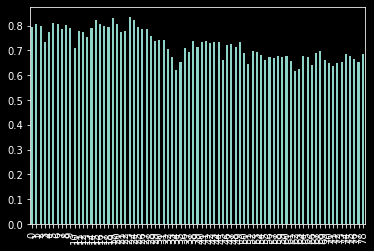

In [5]:
pd.read_csv("results/JSD.csv")["JSD"].plot.bar()

<AxesSubplot:>

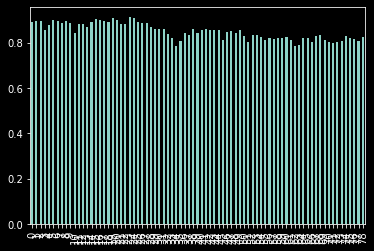

In [7]:
pd.read_csv("results/sqrt_JSD.csv")["sqrt_JSD"].plot.bar()

In [100]:
from io import StringIO

df = pd.read_csv(
    StringIO(
        """element	global_weight	date
york	0.2	01/10/2001
bin laden	0.2	01/10/2001
america	0.1	01/10/2001
uk	0.3	01/10/2001
afghanistan	0.1	01/10/2001
god	0.1	01/10/2001
iraq	0.2	02/10/2001
sudan	0.3	02/10/2001
bush	0.3	02/10/2001
obl	0.2	02/10/2001
"""
    ),
    sep="\t",
)
df

,element,global_weight,date
0,york,0.2,01/10/2001
1,bin laden,0.2,01/10/2001
2,america,0.1,01/10/2001
3,uk,0.3,01/10/2001
4,afghanistan,0.1,01/10/2001
5,god,0.1,01/10/2001
6,iraq,0.2,02/10/2001
7,sudan,0.3,02/10/2001
8,bush,0.3,02/10/2001
9,obl,0.2,02/10/2001


In [9]:
np.array([[1, 2, 3], [3, 3, 5]]).sum(axis=0)

array([4, 5, 8])

In [68]:
def normalize_all(tw_freq):
    to_replace = {}
    e = (
        tw_freq["element"]
        .drop_duplicates()
        .sort_values()
        .reset_index(drop=True)
        .to_dict()
    )
    to_replace["element"] = {v: k for k, v in e.items()}
    d = tw_freq["date"].drop_duplicates().sort_values().reset_index(drop=True).to_dict()
    to_replace["date"] = {v: k for k, v in d.items()}
    tw_freq = tw_freq.replace(to_replace)
    idx = tw_freq[["date", "element"]].to_numpy()
    matrix = np.zeros((len(d), len(e)), dtype="float64")
    matrix[idx[:, 0], idx[:, 1]] = tw_freq["global_weight"]
    return matrix

In [103]:
m = normalize_all(df)
display(m)

array([[0.1, 0.1, 0.2, 0. , 0.1, 0. , 0. , 0. , 0.3, 0.2],
       [0. , 0. , 0. , 0.3, 0. , 0.2, 0.2, 0.3, 0. , 0. ]])

array([0.96, 0.94])

array([[0.096, 0.096, 0.192, 0.01 , 0.096, 0.01 , 0.01 , 0.01 , 0.288,
        0.192],
       [0.01 , 0.01 , 0.01 , 0.282, 0.01 , 0.188, 0.188, 0.282, 0.01 ,
        0.01 ]])

array([1., 1.])

<AxesSubplot:ylabel='Frequency'>

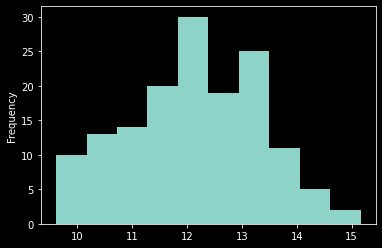

In [11]:
df = pd.read_csv("results/mainstream/squeezed_freq.csv")
df["entropy"] = entropy(df["global_weight"])
df.groupby("date").sum()["entropy"].plot.hist()

In [ ]:
main_entropy = entropy_single(
    base_freq, "mainstream", "W", "2019-11-01", "2020-07-04"
).assign(**{"subcorpus": "mainstream"})
cons_entropy = entropy_single(
    base_freq, "conspiracy", "W", "2019-11-01", "2020-07-04"
).assign(**{"subcorpus": "conspiracy"})
full_ = pd.concat([main_entropy, cons_entropy])
alt.Chart(full_).mark_line().encode(
    x="date:T", y="entropy", color="subcorpus", tooltip=alt.Tooltip("date:T")
).properties(width=900)

In [ ]:
def cumulative_dvr(
    base_freq: pd.DataFrame,
    subcorpus: Subcorpus = "full",
    freq: Literal["MS", "D", "W"] = "MS",
    start_date: str = "1990-01-01",
    end_date: str = "2020-07-01",
    filter_: pd.Series | None = None,
):
    l = []
    s = pd.to_datetime(start_date, format="%Y-%m-%d")
    e = pd.to_datetime(end_date, format="%Y-%m-%d")
    base_freq = base_freq[base_freq["date"] >= s & base_freq["date"] <= e].reset_index(
        drop=True
    )
    # for date in pd.date_range(s,e,freq=freq):
    # freq = freq_window(base_freq, e, True, subcorpus=subcorpus)
    dvr = LPA.create_dvr(freq).assign(**{"date": e, "subcorpus": subcorpus})
    l.append(dvr[dvr["element"] == filter_])
    return pd.concat(l).reset_index(drop=True)

In [ ]:
def entropy_single(base_freq, *dvr_args):
    daily = non_cumulative_dvr(base_freq, *dvr_args)
    res = (
        daily.pivot(index="element", columns="date", values="global_weight")
        .fillna(0)
        .to_numpy()
    )
    kld_res = np.sum(entropy(res), axis=0)
    kldf = pd.DataFrame(
        {
            "date": daily["date"].drop_duplicates().reset_index(drop=True),
            "entropy": kld_res,
        }
    )
    return kldf

In [ ]:
def plot_seasonal_decompose(kldf, arg1="observed", arg2="trend"):
    ts = kldf.set_index("date")
    result = seasonal_decompose(ts, model="additive")
    # result.seasonal.plot()
    # result.resid.plot()
    result = (
        getattr(result, arg1)
        .to_frame(name="observed")
        .join(getattr(result, arg2))
        .reset_index()
        .melt(id_vars="date")
    )
    return (
        alt.Chart(result)
        .mark_line()
        .encode(x="date:T", y="value", color="variable", tooltip=alt.Tooltip("date:T"))
        .properties(width=900)
    )


plot_seasonal_decompose(kldf)

In [ ]:
monthly_conspiracy = non_cumulative_dvr(None, "conspiracy")
monthly_mainstream = non_cumulative_dvr(None, "mainstream")
monthly_conspiracy["subcorpus"] = "conspiracy"
monthly_mainstream["subcorpus"] = "mainstream"
monthly = non_cumulative_dvr()

In [ ]:
daily_args = ("D", "2019-11-01", "2020-07-04")
daily_conspiracy = non_cumulative_dvr(base_freq, "conspiracy", *daily_args)
daily_mainstream = non_cumulative_dvr(base_freq, "mainstream", *daily_args)
daily_conspiracy["subcorpus"] = "conspiracy"
daily_mainstream["subcorpus"] = "mainstream"
daily = non_cumulative_dvr(base_freq, "full", *daily_args)

In [ ]:
def kld_double(dvr_1, dvr_2, epsilon=0):
    dates_union = set(dvr_1["date"].drop_duplicates().tolist()) & set(
        dvr_2["date"].drop_duplicates().tolist()
    )
    d = {"date": [], "KLD": []}
    for date in sorted(dates_union):
        res = pd.concat(
            [
                dvr_1[dvr_1["date"] == date],
                dvr_2[dvr_2["date"] == date],
            ]
        ).pivot(index="element", columns="subcorpus", values="global_weight")
        res = (res / (1 + res.isna().sum() * epsilon)).fillna(epsilon).to_numpy()
        kld_res = np.sum(
            np.apply_along_axis(KLD_divergence_consecutive, 1, res), axis=0
        )
        d["date"].append(date)
        d["KLD"].append(kld_res[0])
    return pd.DataFrame(d)

In [ ]:
comparative_kldf = kld_double(daily_mainstream, daily_conspiracy, epsilon=2e-5)
alt.Chart(comparative_kldf).mark_line().encode(
    x="date:T", y="KLD", tooltip=alt.Tooltip("date:T")
).properties(width=900)

In [ ]:
ts = comparative_kldf.set_index("date")
idx = pd.date_range("2019-11-01", "2020-07-01")
ts.index = pd.DatetimeIndex(ts.index)
ts = ts.reindex(idx, fill_value=0)
result = seasonal_decompose(ts)  # , model='additive', period=241)
result = (
    result.observed.to_frame(name="observed")
    .join(result.trend)
    .reset_index()
    .melt(id_vars="index")
)
alt.Chart(result).mark_line().encode(
    x="index:T", y="value", color="variable", tooltip=alt.Tooltip("index:T")
).properties(width=900)

# result.resid.plot()
# result.observed.plot()

In [ ]:
def word_over_time(
    full_dvr: pd.DataFrame,
    word: List[str] | str,
    save: bool = False,
    cumulative: bool = True,
) -> alt.Chart:
    # dvr must be full cumulative dvr
    dvr = full_dvr[full_dvr["element"].isin((word if isinstance(list) else [word]))]
    selection = alt.selection_multi(fields=["element"], bind="legend")
    chart = alt.Chart(dvr).mark_line() if cumulative else alt.Chart(dvr).mark_bar()
    chart = (
        chart.encode(
            x=alt.X("date:T"),
            y="global_weight",
            color=alt.Color("element", legend=alt.Legend(columns=3, symbolLimit=300)),
            opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
        )
        .add_selection(selection)
        .properties(width=900)
    )
    if save == True:
        chart.save("results/random.html")
    return chart


word_over_time(full_dvr, "vaccin")

In [ ]:
dr = pd.date_range(
    pd.to_datetime("1990-01-01", format="%Y-%m-%d"),
    pd.to_datetime("2022-01-01", format="%Y-%m-%d"),
    freq="MS",
)
s = dr.to_series(name="date")
df = full_dvr[full_dvr["element"] == "world"]
ts = (
    pd.merge(s, df, right_on="date", left_index=True, how="outer")[
        "frequency_in_category"
    ]
    .fillna(0)
    .reset_index(drop=True)
)
ts.index = dr
ts
# ts = df.set_index("date")['frequency_in_category']